# ANN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
df = pd.read_csv("housePrice data.csv", header=None, delim_whitespace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       506 non-null    float64
 1   1       506 non-null    float64
 2   2       506 non-null    float64
 3   3       506 non-null    int64  
 4   4       506 non-null    float64
 5   5       506 non-null    float64
 6   6       506 non-null    float64
 7   7       506 non-null    float64
 8   8       506 non-null    int64  
 9   9       506 non-null    float64
 10  10      506 non-null    float64
 11  11      506 non-null    float64
 12  12      506 non-null    float64
 13  13      506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train = (scaler := StandardScaler()).fit_transform(X_train)
X_test = scaler.transform(X_test)

## Construct 1-hidden layer Neural Network mode

In [4]:
% pip install -q keras-tuner

UsageError: Line magic function `%` not found.


<Axes: xlabel='epochs', ylabel='loss'>

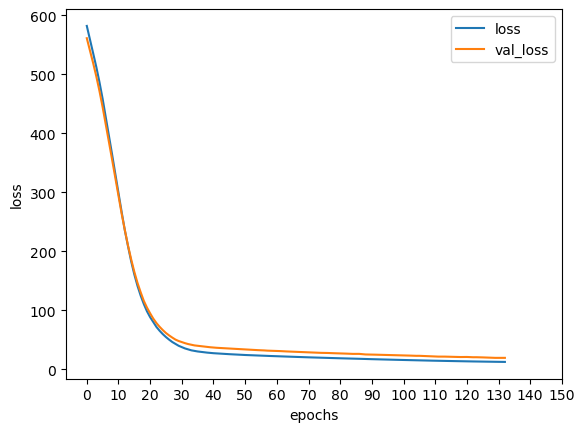

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

tf.random.set_seed(1234)
model = keras.Sequential(
    [layers.InputLayer(input_shape=(13,)), layers.Dense(units=100, activation="relu"), layers.Dense(1)]
)
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss="mean_squared_error",
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2, verbose=0, callbacks=[early_stop])

pd.DataFrame(history.history).plot(xlabel="epochs", ylabel="loss", xticks=np.arange(0, 151, 10))

In [6]:
def build_model(hp: kt.HyperParameters):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(13,)))
    model.add(layers.Dense(units=hp.Int("units", 50, 801, 50), activation="relu"))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=hp.Choice("lr", [1e-4, 1e-3, 1e-2])),
        loss="mean_squared_error",
    )
    return model

In [7]:
tuner = kt.Hyperband(build_model, objective=kt.Objective("val_loss", "min"), project_name="housePrice")
tuner.search(X_train, y_train, epochs=130, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

Trial 42 Complete [00h 00m 00s]
val_loss: 485.80517578125

Best val_loss So Far: 36.02494430541992
Total elapsed time: 00h 00m 14s
{'units': 700, 'lr': 0.01, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


##  Plot loss graph

In [8]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=130)

Epoch 1/130
13/13 [==============================] - 0s 676us/step - loss: 277.8617
Epoch 2/130
13/13 [==============================] - 0s 689us/step - loss: 62.1535
Epoch 3/130
13/13 [==============================] - 0s 662us/step - loss: 30.5427
Epoch 4/130
13/13 [==============================] - 0s 647us/step - loss: 22.7874
Epoch 5/130
13/13 [==============================] - 0s 722us/step - loss: 18.1409
Epoch 6/130
13/13 [==============================] - 0s 661us/step - loss: 14.9387
Epoch 7/130
13/13 [==============================] - 0s 640us/step - loss: 13.2157
Epoch 8/130
13/13 [==============================] - 0s 856us/step - loss: 12.9278
Epoch 9/130
13/13 [==============================] - 0s 718us/step - loss: 11.5908
Epoch 10/130
13/13 [==============================] - 0s 705us/step - loss: 12.4114
Epoch 11/130
13/13 [==============================] - 0s 717us/step - loss: 11.0814
Epoch 12/130
13/13 [==============================] - 0s 671us/step - loss: 11.0470


In [9]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 634us/step


## Evaluate

In [10]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred, squared=True)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)

print("MAE is", MAE)
print("MSE is", MSE)
print("RMAE is", RMSE)

MAE is 1.8372225191078928
MSE is 5.566580888362318
RMAE is 2.359360270997695
